This notebook is based closely on demo_bootstrap.ipynb from the RSA toolbox, by Daniel Lindh (dnllndh@gmail.com).

# Searchlight for RSA

Data used in this tutorial was used in:
[*Cichy, R. M., Pantazis, D., & Oliva, A. (2016). Similarity-based fusion of MEG and fMRI reveals spatio-temporal dynamics in human cortex during visual object recognition. Cerebral Cortex, 26(8), 3563-3579.*](https://academic.oup.com/cercor/article/26/8/3563/2428700)

In this tutorial, we will load a publically available fMRI data set for one participant. The participant passively viewed 118 images (see [project page](https://userpage.fu-berlin.de/rmcichy/fusion_project_page/main.html), where 27 images were animate and 91 were inanimate. Using RSA, we will test an "animate" model to see which voxels most correspond to the animate category. 

The steps will be:
1. Load data
2. Get the searchlight centers with the corresponding neighboring voxels 
3. Calculate an RDM for each searchlight ROI
4. Define a model RDM (animate/inanimate)
5. Evaluate each searchlight RDM against the model RDM
6. Plot results


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from glob import glob
import rsatoolbox
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight  

%matplotlib inline

## 1. Load data

Cichy's fMRI data (subject 2) has been downloaded from [here](http://wednesday.csail.mit.edu/MEG2_fMRI_Clear_Data/), unzipped and placed in the "data_folder" below.

This particular data set consists of one .img file per volume, so we need to loop over each file and add them to a data array.

In [2]:
# set this path to wherever you saved the folder containing the img-files
data_folder = 'rsatoolbox_demos_2025/Cichy16_subj02'

image_paths = list(glob(f"{data_folder}/con_*.img"))
image_paths.sort()

# load one image to get the dimensions and make the mask
tmp_img = nib.load(image_paths[0])
# we infer the mask by looking at non-nan voxels
mask = ~np.isnan(tmp_img.get_fdata())
x, y, z = tmp_img.get_fdata().shape

# loop over all images
data = np.zeros((len(image_paths), x, y, z))
for x, im in enumerate(image_paths):
    data[x] = nib.load(im).get_fdata()

# only one pattern per image
stimulus = np.arange(len(image_paths))

#print(image_paths)
print('Shape of mask:', mask.shape)
print('Shape of data:', data.shape)

Shape of mask: (53, 63, 46)
Shape of data: (118, 53, 63, 46)


## 2. Get searchlight centers and neighbours

In this example, each ROI includes voxels up to 3 voxels from the central voxel (smaller is faster). An ROI is excluded if < 50% of these voxels are within the brain mask (threshold=0.5). 

In [3]:
centers, neighbours = get_volume_searchlight(mask, radius=3, threshold=0.5)

Finding searchlights...: 100%|██████████| 61044/61044 [00:11<00:00, 5507.39it/s]


Found 58636 searchlights


## 3. Calculate RDM for each searchlight ROI

Now we pass the data, searchlight parameters, and dissimilariy "method" to the `get_searchlight_RDMs` function:

In [4]:
# reshape data so we have n_observastions x n_voxels
data_2d = data.reshape([data.shape[0], -1])
data_2d = np.nan_to_num(data_2d)
print('New shape of data:', data_2d.shape)

# Get RDMs
SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbours, stimulus, method='euclidean') # this takes about ~3-5 minutes
# (see rsatoolbox.rdm.calc for available methods)

New shape of data: (118, 153594)


Calculating RDMs...: 100%|████████████████████| 100/100 [04:20<00:00,  2.61s/it]


In [5]:
print(SL_RDM.n_rdm, 'searchlight centres')
# print(SL_RDM[0])

58636 searchlight centres


## 4. Define model RDM and evaluate its fit to the data RDMs

Now we need to define one or more model RDMs. We'll base this on whether each stimulus is animate or inanimate:

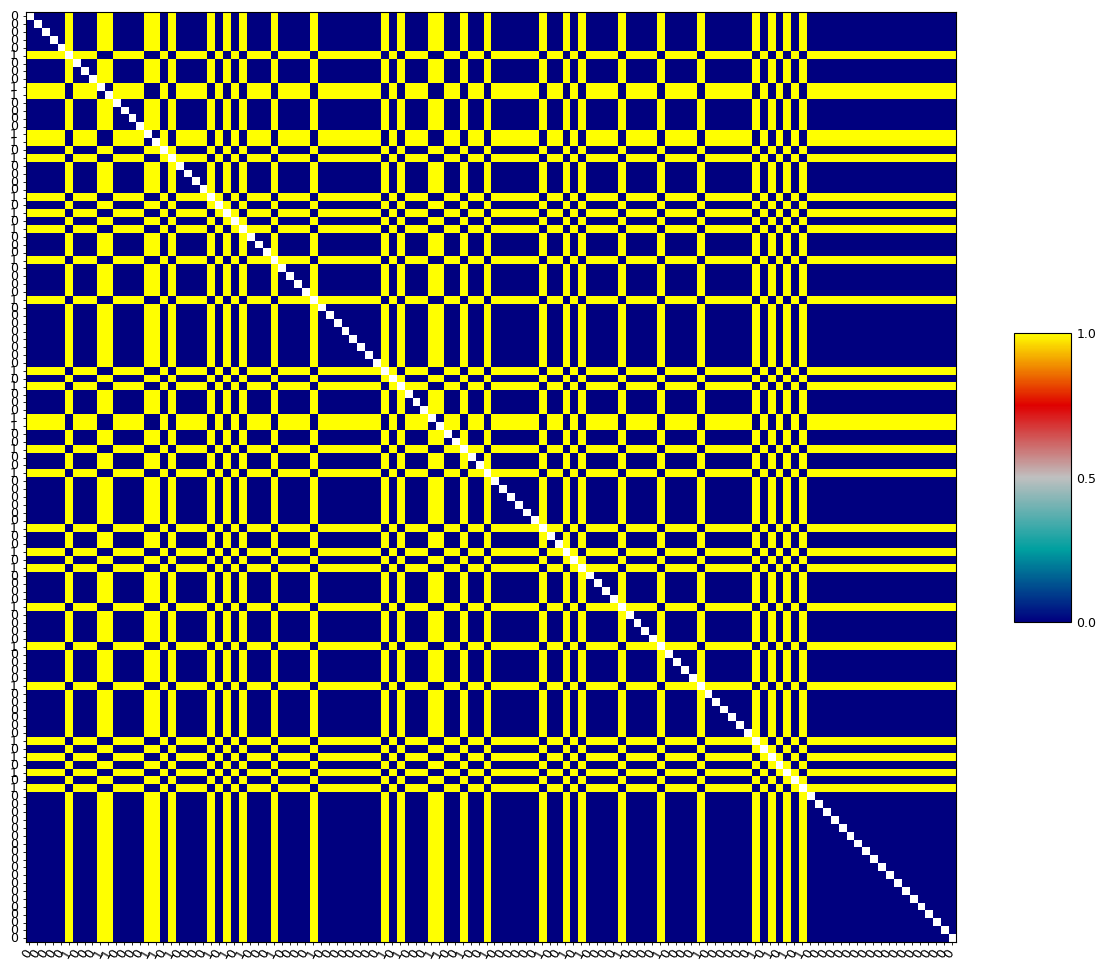

In [23]:
# Load animacy labels for each stimulus:
an_labels = np.load('rsatoolbox_demos_2025/118_images_files/118_animate_labels.npy')

# We could load a model RDM that has a 0 wherever both pair-wise comparisons are animate and otherwise 1:
an_RDM    = np.load('rsatoolbox_demos_2025/118_images_files/118_animate_RDM.npy')
an_RDM    = rsatoolbox.rdm.RDMs(np.expand_dims(an_RDM,0), pattern_descriptors={'IsAnimate': an_labels}) # the RDMs object has # RDMs as the first dimension
# This assumes that inanimate objects are as different to each other as they are to animate objects, which are less different to each other.
# (It seems to fit the brain data better for correlation distance than euclidean distance RDMs?) 

# Instead, we'll create a model RDM that treats animate and inanimate objects as two categories, with objects more similar within than between categories: 
an_RDM = rsatoolbox.rdm.get_categorical_rdm([1 if i=='Animate' else 0 for i in an_labels], 'IsAnimate')

# Put it into a fixed model object:
an_model  = ModelFixed('Animate RDM', an_RDM)

# Display it:
# print(an_RDM)
rsatoolbox.vis.rdm_plot.show_rdm(an_model.rdm_obj, show_colorbar='panel', cmap='classic',figsize=(15,15), pattern_descriptor='IsAnimate');

## 5. Evaluate model

Now we can evaluate the fit of the model RDM(s) to the data RDMs from each searchlight ROI:

In [14]:
eval_results = evaluate_models_searchlight(SL_RDM, an_model, eval_fixed, method='corr', n_jobs=-1)
# See rsatoolbox.rdm.compare.compare for accepted comparison methods 
# ('corr' is fastest, taking ~ 1 min in parallel)

Evaluating models for each searchlight: 100%|█| 58636/58636 [00:54<00:00, 1077.6


We only have one model, but, for each voxel, the function returns a list of scores across possible models. So we will grab the value within that list, for each voxel. Then we will put these into a 3D array, with the size of the brain mask:

In [15]:
eval_score = [(e.evaluations[0,0,0]) for e in eval_results]

print('Correlation of model RDM with one ROI RDM: ', eval_score[0])

x, y, z = mask.shape
rho_brain = np.zeros([x*y*z])
rho_brain[ list(SL_RDM.rdm_descriptors['voxel_index']) ] = eval_score
rho_brain = rho_brain.reshape([x, y, z])

print('Shape of brain mask: ', rho_brain.shape)

Correlation of model RDM with one ROI RDM:  0.03075892530512798
Shape of brain mask:  (53, 63, 46)


## 6. Plot results

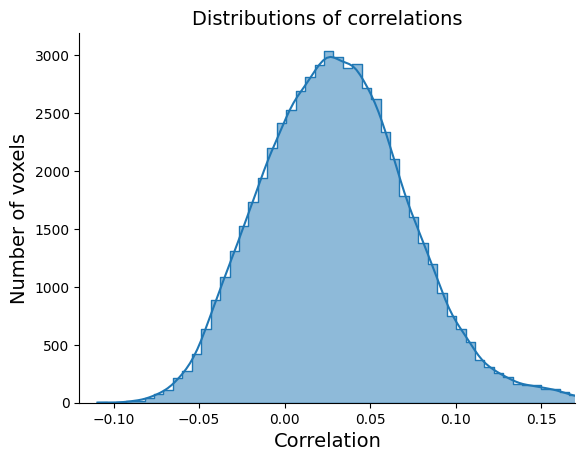

In [22]:
sns.histplot(eval_score, bins = "rice", kde = True, element = "step")
plt.title('Distribution of correlations', size = 14)
plt.ylabel('Number of voxels', size = 14)
plt.xlabel('Correlation', size = 14)
plt.xlim(-0.12, 0.17)
sns.despine()
plt.show()

Finally, let's plot the brain data using nilearn. We would expect the animacy model to best explain brain representations along the ventral visual stream.

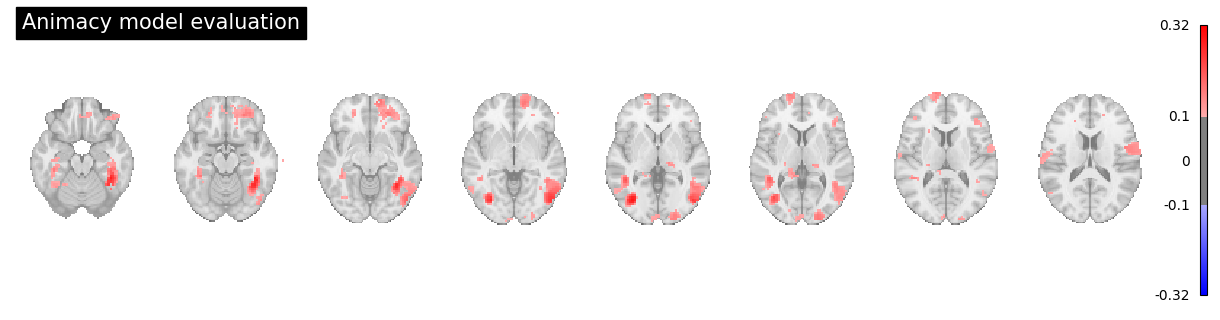

In [20]:
plot_img = new_img_like(tmp_img, rho_brain) # put the 3D array into a nifti image object

fig = plt.figure(figsize=(12, 3))
display = plotting.plot_stat_map(plot_img, 
                                 colorbar = True, 
                               cut_coords = range(-20, 20, 5), # z coordinates to display
                                threshold = np.percentile(eval_score, 95), # plot the voxels above the 99th percentile
                             display_mode = 'z', 
                               draw_cross = False, 
                                   figure = fig, 
                                    title = 'Animacy model evaluation', 
                                     cmap = 'bwr', 
                                 black_bg = False, 
                                 annotate = False)
plt.show()